In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.preprocessing
from sklearn.metrics import r2_score
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

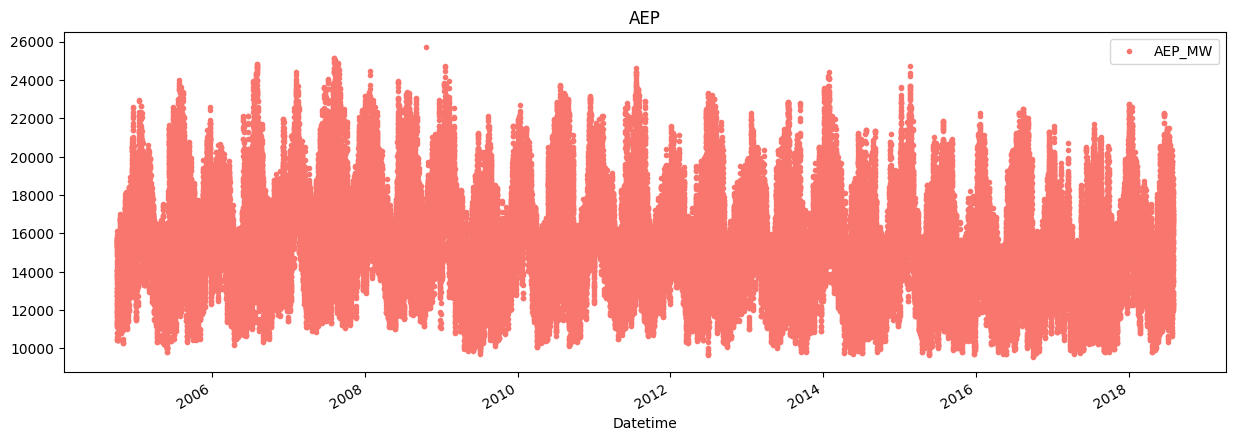

In [ ]:
AEP=pd.read_csv("AEP_hourly.csv", index_col=[0], parse_dates=[0])
mau = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
bieudo = AEP.plot(style='.', figsize=(15,5), color=mau[0], title='AEP')

In [ ]:
AEP.head(5)

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [ ]:
def create_features(df, label=None):
  df=df.copy()
  df['date']=df.index
  df['hour']=df['date'].dt.hour
  df['daysofweek']=df['date'].dt.dayofweek
  df['quater']=df['date'].dt.quarter
  df['month']=df['date'].dt.month
  df['year']=df['date'].dt.year
  df['dayofyear']=df['date'].dt.dayofyear
  df['dayofmonth']=df['date'].dt.day
  df['weekofyear'] = df['date'].dt.isocalendar().week
  return df

  X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']]
  if label:
     y=df[label]
     return X,y
  return X



In [ ]:
df_with_features = create_features(AEP)
print(df_with_features)

                      AEP_MW                date  hour  daysofweek  quater  \
Datetime                                                                     
2004-12-31 01:00:00  13478.0 2004-12-31 01:00:00     1           4       4   
2004-12-31 02:00:00  12865.0 2004-12-31 02:00:00     2           4       4   
2004-12-31 03:00:00  12577.0 2004-12-31 03:00:00     3           4       4   
2004-12-31 04:00:00  12517.0 2004-12-31 04:00:00     4           4       4   
2004-12-31 05:00:00  12670.0 2004-12-31 05:00:00     5           4       4   
...                      ...                 ...   ...         ...     ...   
2018-01-01 20:00:00  21089.0 2018-01-01 20:00:00    20           0       1   
2018-01-01 21:00:00  20999.0 2018-01-01 21:00:00    21           0       1   
2018-01-01 22:00:00  20820.0 2018-01-01 22:00:00    22           0       1   
2018-01-01 23:00:00  20415.0 2018-01-01 23:00:00    23           0       1   
2018-01-02 00:00:00  19993.0 2018-01-02 00:00:00     0          

In [ ]:
df=pd.read_csv('DOM_hourly.csv',index_col='Datetime',parse_dates=['Datetime'])
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [ ]:
df.isna().sum()

,0
DOM_MW,0


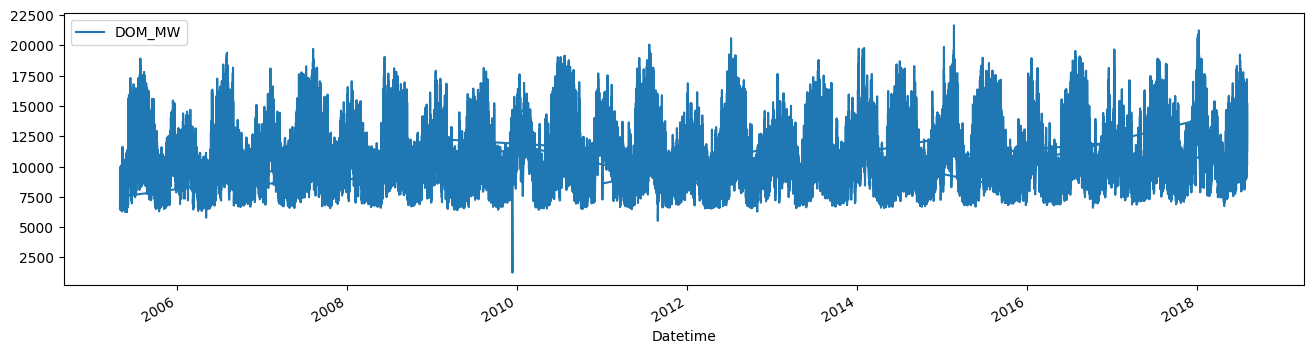

In [ ]:
df.plot(figsize=(16,4))
plt.show()

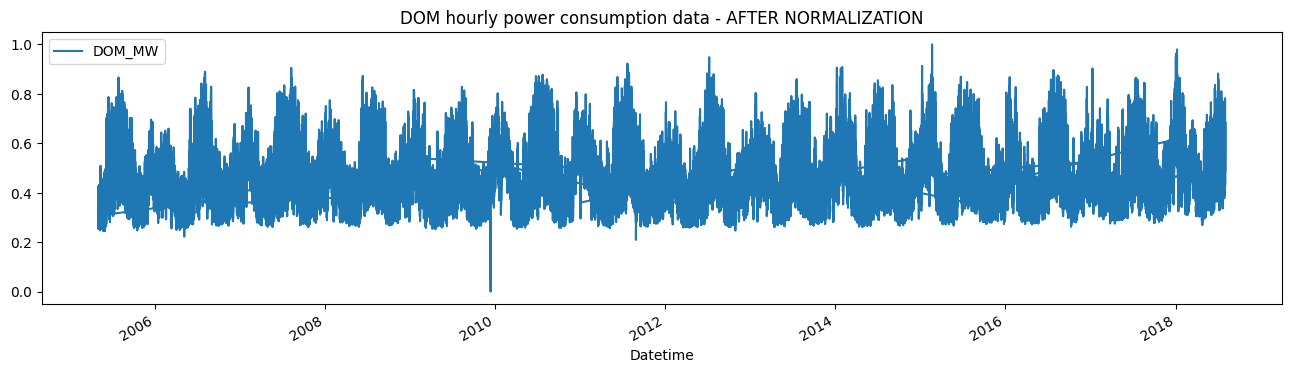

In [ ]:
##Normalize
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

#Visualize data after normalization

df_norm.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()


In [ ]:
# train data for deep learning models

def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i - seq_len: i, 0])
        y_train.append(stock.iloc[i, 0])

    X_test = X_train[110000:]
    y_test = y_train[110000:]

    X_train = X_train[:110000]
    y_train = y_train[:110000]

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    #reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))

    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))

    return [X_train, y_train, X_test, y_test]

In [ ]:
# Check your columns

seq_len = 20

X_train, y_train, X_test, y_test = load_data(df,seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


In [ ]:
#RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))
rnn_model.add(Dense(1))
rnn_model.summary()
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 20, 40)         │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 20, 40)         │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,201 (32.04 KB)

 Trainable params: 8,201 (32.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - loss: 0.1773
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - loss: 0.0285
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 96ms/step - loss: 0.0142
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0097
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - loss: 0.0073
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - loss: 0.0060
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - loss: 0.0050
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - loss: 0.0044
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - loss: 0.0039
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.0035


In [13]:
rnn_predictions = rnn_model.predict(X_test)
rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
R2 Score of RNN model =  0.9394322226943517


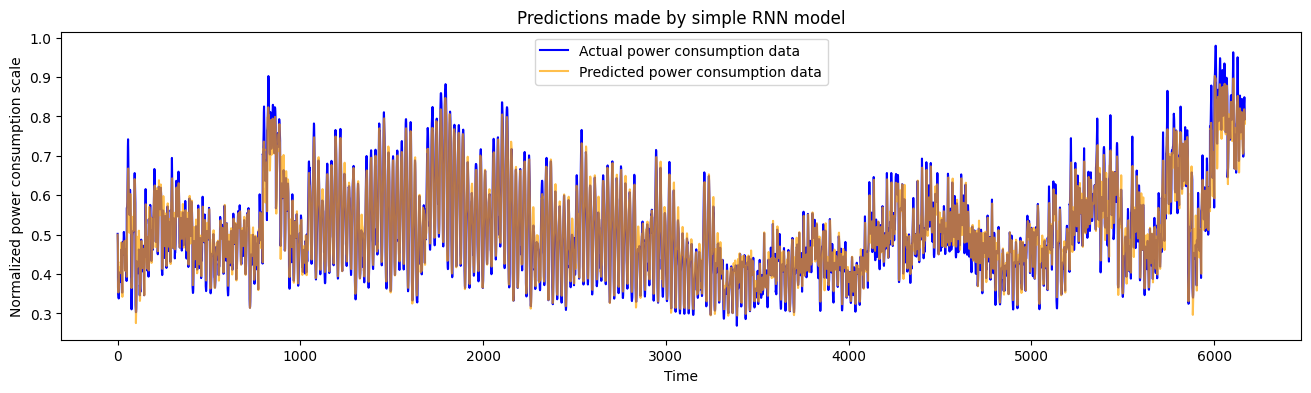

In [14]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16, 4))
    plt.plot(test, color='blue', label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange', label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

In [15]:
lstm_model = Sequential()
lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(1))
lstm_model.summary()
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 40)         │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 40)         │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 40)             │        12,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,681 (127.66 KB)

 Trainable params: 32,681 (127.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 32s 233ms/step - loss: 0.0460
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 228ms/step - loss: 0.0122
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 219ms/step - loss: 0.0081
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 42s 232ms/step - loss: 0.0046
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step - loss: 0.0037
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 219ms/step - loss: 0.0029
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 217ms/step - loss: 0.0025
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 217ms/step - loss: 0.0022
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 24s 218ms/step - loss: 0.0020
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 41s 218ms/step - loss: 0.0018


In [16]:
lstm_predictions = lstm_model.predict(X_test)
lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

193/193 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
R^2 Score of LSTM model =  0.9503250585427323


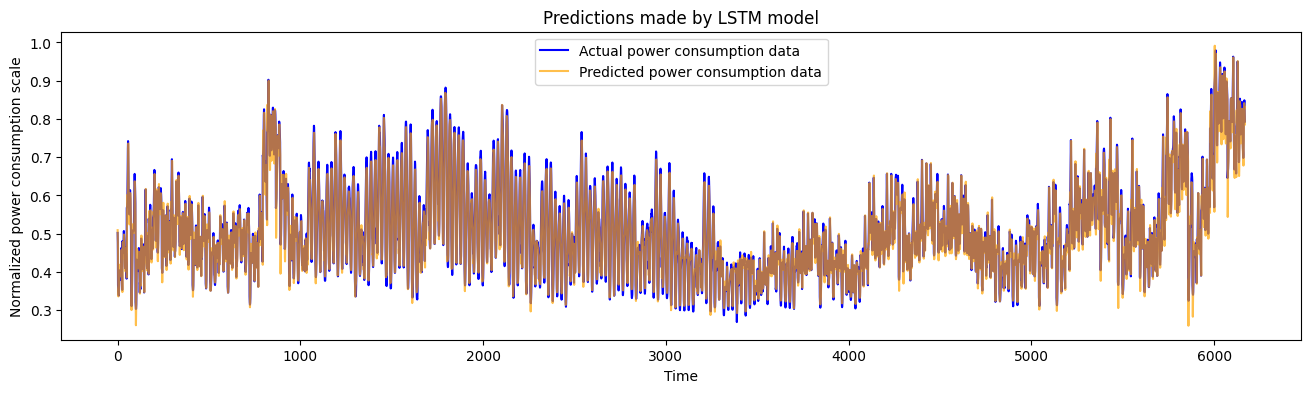

In [18]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

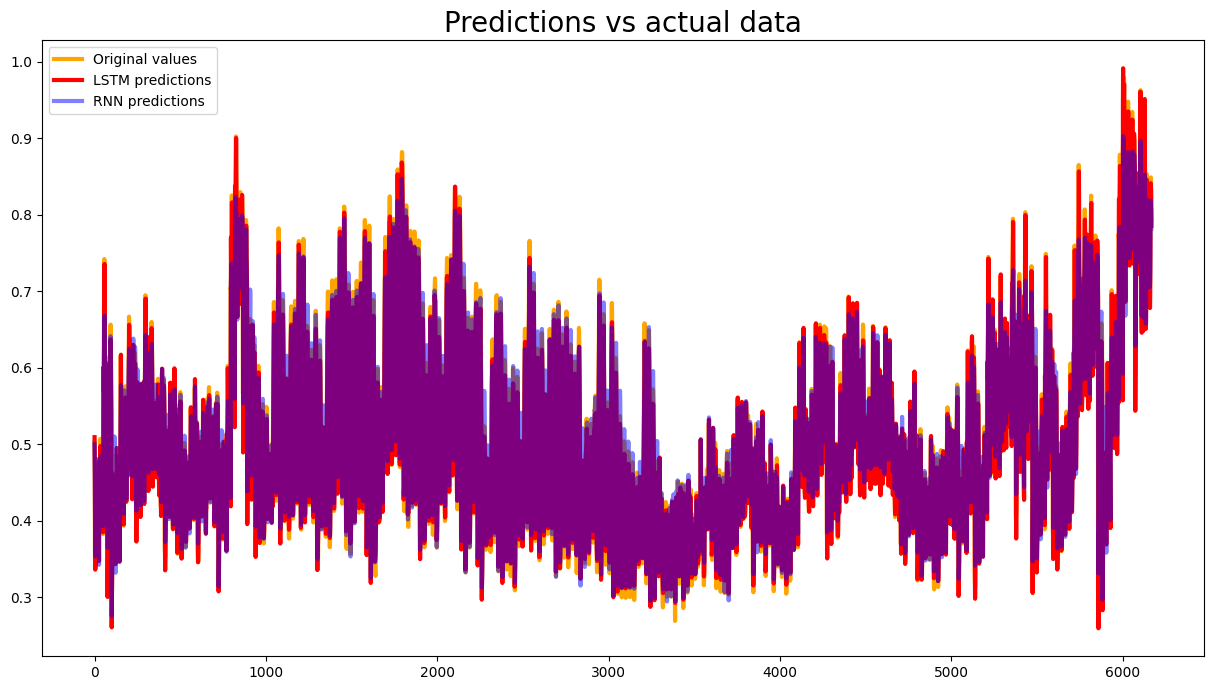

In [19]:
plt.figure(figsize=(15,8))
plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="blue", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()